In [1]:
import os
os.chdir('..')
import h5py
import numpy as np
import cartopy.crs as ccrs
from notebooks import config
import numpy as np
from utils.imgShow import imgShow
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.transform_xy import coor2coor
from utils.mad_std import mad_std
from scipy.optimize import curve_fit


In [2]:
path_img = config.root + '/data/rs_img/pine_island_S3A_20180207T115228_20180207T115528.tif'
path_atl06_spot1_A = config.root + '/data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_spot1_A.h5'
path_atl06_spot1_D = config.root + '/data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_spot1_D.h5'
path_atl06_A = config.root + '/data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_A.h5'
path_atl06_D = config.root + '/data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D.h5'


In [3]:
s3_img, s3_img_info = readTiff(path_img)
print(s3_img_info)


{'geoextent': (-1741002.5304, -1437153.6139, -380178.3167, -165679.325), 'geotrans': (-1741002.5304, 295.8606781888998, 0.0, -165679.325, 0.0, -295.8606782068966), 'geosrs': '3031', 'row': 725, 'col': 1027, 'bands': 3}


In [4]:
# with h5py.File(path_atl06_spot1_A,'r') as f_a:
with h5py.File(path_atl06_A,'r') as f_a:
    print(f_a.keys())
    lat_A   = f_a['lat'][:]
    lon_A   = f_a['lon'][:]
    h_elv_A = f_a['h_elv'][:]
    t_yrs_A = f_a['t_year'][:]
    spot_A = f_a['spot'][:]

# with h5py.File(path_atl06_spot1_D,'r') as f_d:
with h5py.File(path_atl06_D,'r') as f_d:
    print(f_d.keys())
    lat_D   = f_d['lat'][:]
    lon_D   = f_d['lon'][:]
    h_elv_D = f_d['h_elv'][:]
    t_yrs_D = f_d['t_year'][:]
    spot_D = f_d['spot'][:]

## filtering the invalid points.
## -- remove outlier values
## ascending
idx_valid = np.where( (h_elv_A >= -500) & (h_elv_A <= 9000) )
lat_A, lon_A, h_elv_A  = lat_A[idx_valid], lon_A[idx_valid], h_elv_A[idx_valid], 
t_yrs_A, spot_A = t_yrs_A[idx_valid], spot_A[idx_valid]
## descending
idx_valid = np.where( (h_elv_D >= -500) & (h_elv_D <= 9000) )
lat_D, lon_D, h_elv_D = lat_D[idx_valid], lon_D[idx_valid], h_elv_D[idx_valid]
t_yrs_D, spot_D = t_yrs_D[idx_valid], spot_D[idx_valid]

x_A, y_A = coor2coor(srs_from=4326, srs_to=s3_img_info['geosrs'], x=lon_A, y=lat_A)
x_D, y_D = coor2coor(srs_from=4326, srs_to=s3_img_info['geosrs'], x=lon_D, y=lat_D)


<KeysViewHDF5 ['beam_type', 'cycle', 'h_elv', 'lat', 'lon', 'quality_summary', 'rgt', 'spot', 't_year']>
<KeysViewHDF5 ['beam_type', 'cycle', 'h_elv', 'lat', 'lon', 'quality_summary', 'rgt', 'spot', 't_year']>


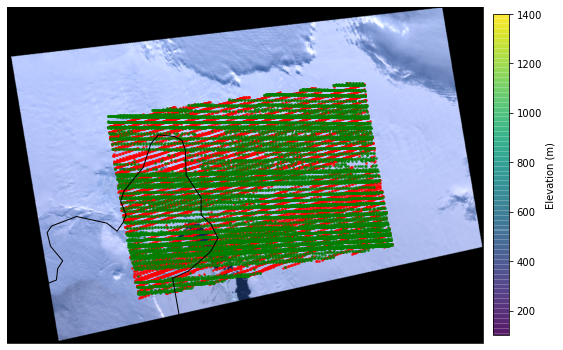

In [5]:
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], \
                        color_bands=(0, 1, 2), clip_percent=5)
# plt.scatter(lon_A_proj[::100], lat_A_proj[::100], s=3, c=h_elv_A[::100], alpha=.7, cmap='terrain')
# plt.scatter(lon_D_proj[::100], lat_D_proj[::100], s=3, c=h_elv_D[::100], alpha=.7, cmap='terrain')
plt.scatter(x_A[::100], y_A[::100], s=3, alpha=.7, c='red')
plt.scatter(x_D[::100], y_D[::100], s=3, alpha=.7, c='green')

plt.clim([100,1400])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')


In [6]:
# !python utils_main/xover_.py -h


In [7]:
# !python utils_main/xover_.py data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_A.h5 data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D.h5 -o data/icesat2/land_ice_antarctic/preprocessed/pineisland_xovers.h5 -p 3031 -d 10 -k 20 -v spot lon lat t_year h_elv



In [86]:
with h5py.File('data/icesat2/land_ice_antarctic/preprocessed/pineisland_xovers.h5','r') as f_xo:
    lon_xovers = f_xo['lon'][:]
    lat_xovers = f_xo['lat'][:]
    t_xovers = f_xo['t_year_as'][:]
    dh_xovers = f_xo['h_elv_dif'][:]
    dt_xovers = f_xo['t_year_dif'][:]
    print(f_xo.keys())

## filtering invalid points, np.abs(dh) < 5
idx_valid = np.where( (np.abs(dh_xovers) <= 5) )
lon_xovers, lat_xovers = lon_xovers[idx_valid], lat_xovers[idx_valid]
t_xovers, dt_xovers, dh_xovers = t_xovers[idx_valid], dt_xovers[idx_valid], dh_xovers[idx_valid]

dhdt_xovers = dh_xovers/dt_xovers
lon_xovers_proj, lat_xovers_proj = coor2coor('4326', '3031', lon_xovers, lat_xovers)


<KeysViewHDF5 ['h_elv_as', 'h_elv_des', 'h_elv_dif', 'lat', 'lon', 'spot_as', 'spot_des', 't_year_as', 't_year_des', 't_year_dif']>


Text(0.5, 0, 'dt_xovers')

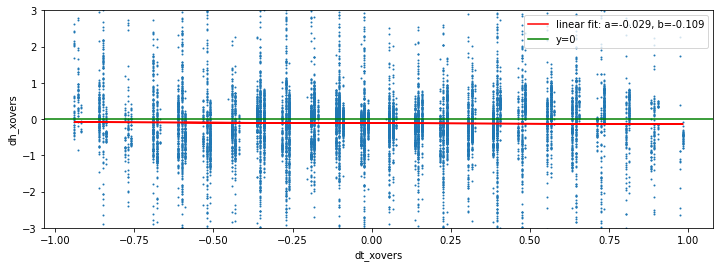

In [106]:
### define fitting function
def func_exp(x, a, b, c):
    return a * np.exp(-b * x) + c
def func_linear(x, a, b):
    return a*x + b

# popt, pcov = curve_fit(func_exp, xdata=dt_xovers, ydata=dh_xovers)
popt, pcov = curve_fit(func_linear, xdata=dt_xovers, ydata=dh_xovers)

### visulization
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(dt_xovers, dh_xovers, '.', markersize=2)
ax.plot(dt_xovers, func_linear(dt_xovers, *popt), 'r-',
         label='linear fit: a=%3.3f, b=%3.3f' % tuple(popt))
# ax.plot(dt_xovers, func_exp(dt_xovers, *popt), 'r-',
#          label='linear fit: a=%3.3f, b=%3.3f, c=%3.3f' % tuple(popt))

ax.axhline(y=0, color='g', label='y=0')
ax.legend()
plt.ylim(-3, 3)
plt.ylabel('dh_xovers')
plt.xlabel('dt_xovers')


## Distribution of the crossover points:   
1) all the crossover points; 
2) that time interval larger 3 months.

Text(0.5, 1.0, 'filtered xover points by dt')

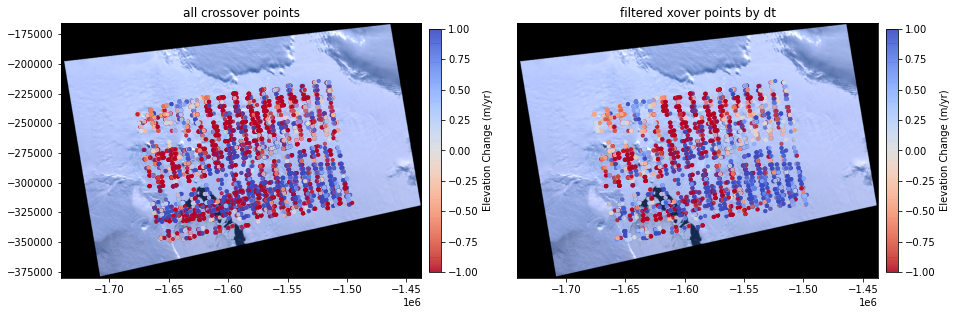

In [100]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

### all crossover points
plt.subplot(1,2,1)
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_xovers_proj, lat_xovers_proj, s=10, c=dh_xovers/dt_xovers, \
                            alpha=.7, cmap='coolwarm_r')
plt.clim([-1.,1.])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation Change (m/yr)')
plt.title('all crossover points')

### filtered crossover points: dt > 3 month
plt.subplot(1,2,2)
ids = np.abs(dt_xovers)> 3./12
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_xovers_proj[ids], lat_xovers_proj[ids], s=10, c=dh_xovers[ids]/dt_xovers[ids], \
                            alpha=.7, cmap='coolwarm_r')
plt.clim([-1.,1.])
plt.yticks([])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation Change (m/yr)')
plt.title('filtered xover points by dt')
